# Assignment 04: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [2]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _WeightedLoss

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

from examples.common.dataset import build_dataset
from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import SplitPredictor
from torchcp.classification.scores import THR
from torchcp.utils import fix_randomness

### Hyperparameters

In [3]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=2.0


### Device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [5]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [8]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [9]:
def train_batch(model, image, target):

    output = model(image)
    loss = criterion(output, target)

    return output, loss

In [10]:

def test_batch(model, image, target):
   
    output = model(image)
    loss = criterion(output, target)

    return output, loss

### Model Training

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 使用CIFAR-10数据集替换MNIST
train_dataset = train_set
train_data_loader = train_dataloader

test_dataset = test_set

cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 使用适合CIFAR-10数据集的网络结构替换原来的网络
model = ConvNet().to(device)  # 假设ConvNet是您定义的网络结构

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


In [12]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    num_batches = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    avg_loss = total_loss / num_batches
    return avg_loss

In [13]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    total_correct = 0
    num_batches = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # 计算预测的类别
        _, predicted = torch.max(output.data, 1)
        # 更新正确预测的数量
        total_correct += (predicted == target).sum().item()
        num_batches += 1
    avg_loss = total_loss / num_batches
    # 计算精度
    accuracy = total_correct / (num_batches * train_loader.batch_size)
    return avg_loss, accuracy


############################## ConfTr #########################
Result--Coverage_rate: 0.9884, Average_size: 6.0388


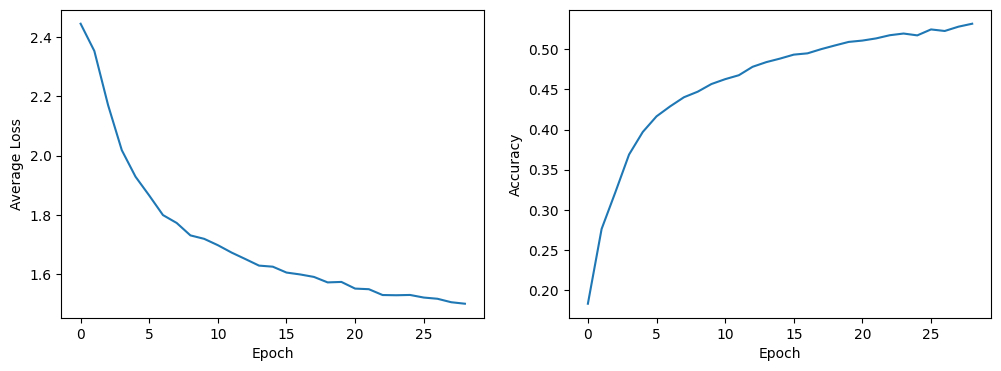

In [14]:
if __name__ == '__main__':
    alpha = 0.01
    num_trials = 5
    loss = "ConfTr"
    result = {}
    print(f"############################## {loss} #########################")
    
    predictor = SplitPredictor(score_function=THR(score_type="log_softmax"))
    criterion = ConfTr(weight=0.01,
                        predictor=predictor,
                        alpha=0.05,
                        fraction=0.5,
                        loss_type="valid",
                        base_loss_fn=nn.CrossEntropyLoss())
        
    fix_randomness(seed=0)
    
    # 创建两个空列表来保存每个训练周期的平均损失和精度
    avg_losses = []
    accuracies = []
    for epoch in range(1, 30):
        avg_loss, accuracy = train(model, device, train_data_loader, criterion, optimizer, epoch)
        avg_losses.append(avg_loss)
        accuracies.append(accuracy)
    
    score_function = THR()

    predictor = SplitPredictor(score_function, model)
    predictor.calibrate(cal_data_loader, alpha)                
    result = predictor.evaluate(test_data_loader)
    print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']}")

    # 使用matplotlib来创建折线图
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(avg_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from examples.common.dataset import build_dataset
from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import SplitPredictor
from torchcp.classification.scores import THR
from torchcp.utils import fix_randomness
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.fc1 = nn.Linear(28 * 28, 500)
                self.fc2 = nn.Linear(500, 10)

            def forward(self, x):
                x = x.view(-1, 28 * 28)
                x = F.relu(self.fc1(x))
                x = self.fc2(x)
                return x
            
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    num_batches = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    avg_loss = total_loss / num_batches
    return avg_loss

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = build_dataset("mnist")
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True)
test_dataset = build_dataset("mnist", mode='test')
cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=1600, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1600, shuffle=False, pin_memory=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

############################## ConfTr #########################
Result--Coverage_rate: 0.9902, Average_size: 1.694


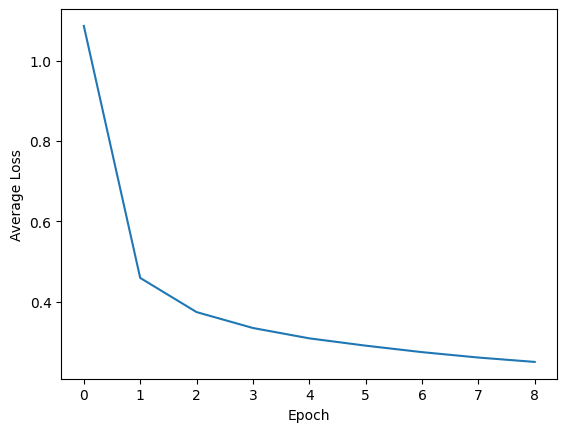

In [4]:
if __name__ == '__main__':
    alpha = 0.01
    num_trials = 5
    loss = "ConfTr"
    result = {}
    print(f"############################## {loss} #########################")
    
    predictor = SplitPredictor(score_function=THR(score_type="log_softmax"))
    criterion = ConfTr(weight=0.01,
                        predictor=predictor,
                        alpha=0.05,
                        fraction=0.5,
                        loss_type="valid",
                        base_loss_fn=nn.CrossEntropyLoss())
        
    fix_randomness(seed=0)
    
    # 创建一个空列表来保存每个训练周期的平均损失
    avg_losses = []
    for epoch in range(1, 10):
        avg_loss = train(model, device, train_data_loader, criterion, optimizer, epoch)
        avg_losses.append(avg_loss)
    
    score_function = THR()

    predictor = SplitPredictor(score_function, model)
    predictor.calibrate(cal_data_loader, alpha)                
    result = predictor.evaluate(test_data_loader)
    print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']}")

    # 使用matplotlib来创建折线图
    plt.plot(avg_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.show()
